In [1]:
!pip install --ignore-installed  numpy>=1.20.3 python-dateutil==2.8.2 eo-learn basemap folium

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

### eo-learn imports

In [3]:
from eolearn.core import EOTask, EOWorkflow, FeatureType, OutputTask, linearly_connect_tasks

# filtering of scenes
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRasterTask
from eolearn.io import SentinelHubInputTask, SentinelHubEvalscriptTask

import getpass

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Sentinelhub configuration

Sentinelhub offers an Application Programming Interface (API), which is an intermediary that allows applications to access the features or data of another application or system. SentinelHub API allows users to programmatically process satellite data and integrate it into their own applications. 

We need to configure our Sentinelhub account in order to get the data we want for our analysis here.

In [4]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = getpass.getpass('Instance Id')
config.sh_client_id = getpass.getpass('Client Id')
config.sh_client_secret = getpass.getpass('Client Secret')
config.save()

Instance Id········
Client Id········
Client Secret········


### Other imports 

In [5]:
# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import pandas as pd
import geopandas as gpd

import folium

# import matplotlib
import matpl
import matplotlib.pyplot as plt
import seaborn as sns

# The golden standard: numpy and matplotlib
import numpy as np

import time 

import datetime as dt


import math

# Loading polygon of nominal water extent
import shapely.wkt
import shapely
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

# Image manipulations
# Our water detector is going to be based on a simple threshold
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# sentinelhub-py package
from sentinelhub import CRS, BBox, DataCollection, Band, Unit, SentinelHubBYOC, UtmZoneSplitter


from helpers import evalscript_template, plot_tiff_folium, plot_multiple_foliums, EWC, construct_cmap, rgb_int

### Area of interest 


Nigeria regularly experiences seasonal flooding. In the past three years, floods have become the second most recurrent hazard affecting Nigeria after epidemics, with flood events peaking around August and October.

The damage caused by the 2022 floods is greater than any single flood event recorded in the country. 


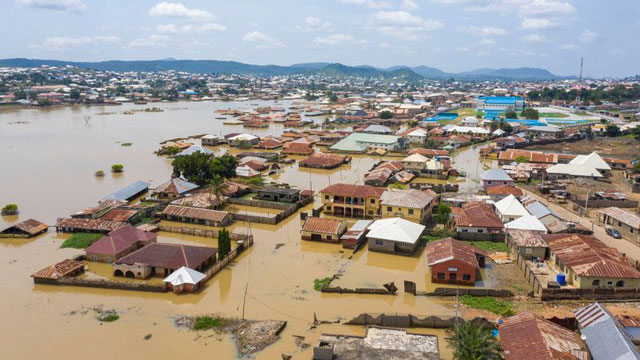

The impact of the flood events is far-reaching, even worse than the 2012 floods that led to an estimated loss of $17 billion.

As of September 2022, inflation in Nigeria reached its highest in 17 years, and the impact of the flood could cause further strain on the economy.

The total financial loss caused by the ongoing floods is yet to be ascertained. However, the country has incurred significant losses across some of its dominant sectors, including agriculture, health and energy. As an example, the World Food Programme reported that over 630,000 hectares of farmland had been destroyed since the floods began in June 2022.


In [13]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

wkt_meteo = 'POLYGON ((2.1823169415786765 14.153692482188347, 2.1823169415786765 4.277408714530779, 15.420004728054494 4.277408714530779, 15.420004728054494 14.153692482188347, 2.1823169415786765 14.153692482188347))'
#'POLYGON ((5.19880059978999 9.110668650183953, 5.19880059978999 6.244087519901015, 8.488100984294249 6.244087519901015, 8.488100984294249 9.110668650183953, 5.19880059978999 9.110668650183953))'
wkt = 'POLYGON ((6.625903941966982 8.001095807654053, 6.625903941966982 7.678229180820395, 6.9837551476568365 7.678229180820395, 6.9837551476568365 8.001095807654053, 6.625903941966982 8.001095807654053))'

polygon_meteo = shapely.wkt.loads(wkt_meteo)
polygon = shapely.wkt.loads(wkt)

# inflate the BBOX

minx, miny, maxx, maxy = polygon.bounds

bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)
bbox_meteo = BBox(list(polygon_meteo.bounds), crs=CRS.WGS84)

resolution = 120
cache_folder = '/home/jovyan/data'

## If we would want to apply to bigger regions, we would need to divide our requests to fit
# patch_size = 2500
# 

## #%% create a splitter to obtain a list of bboxes
# bbox_splitter = UtmZoneSplitter([bbox], bbox.crs, patch_size*resolution)

# bbox_list = np.array(bbox_splitter.get_bbox_list())
# from now on, use each bbox in bbox_list insetad of bbox directly


In [7]:
import folium

gdf = gpd.GeoDataFrame(index=[0,1],geometry=[polygon_meteo,polygon])
gdf

m = folium.Map(location=[6.2, 5.2], zoom_start=5, tiles='CartoDB positron')
for _, r in gdf.iterrows():
    
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()

    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m


### Data sources of interest

We will be looking at the following data sources:
- Meteorological Data (meteoblue), through GEM Data cube
- Sentinel-2 data
- Sentinel-1 data
- ESA World cover data

### Meteo Data

The meteoblue Dataset API helps to optimise your project planning with weather and environmental data customised to the specific requirements of your use case. The high-speed interface makes the API's configuration easy and allows requests for single and multiple points, as well as polygons or administrative areas. All data is constantly updated and our usage-based pricing assures that you pay only for the data you need.


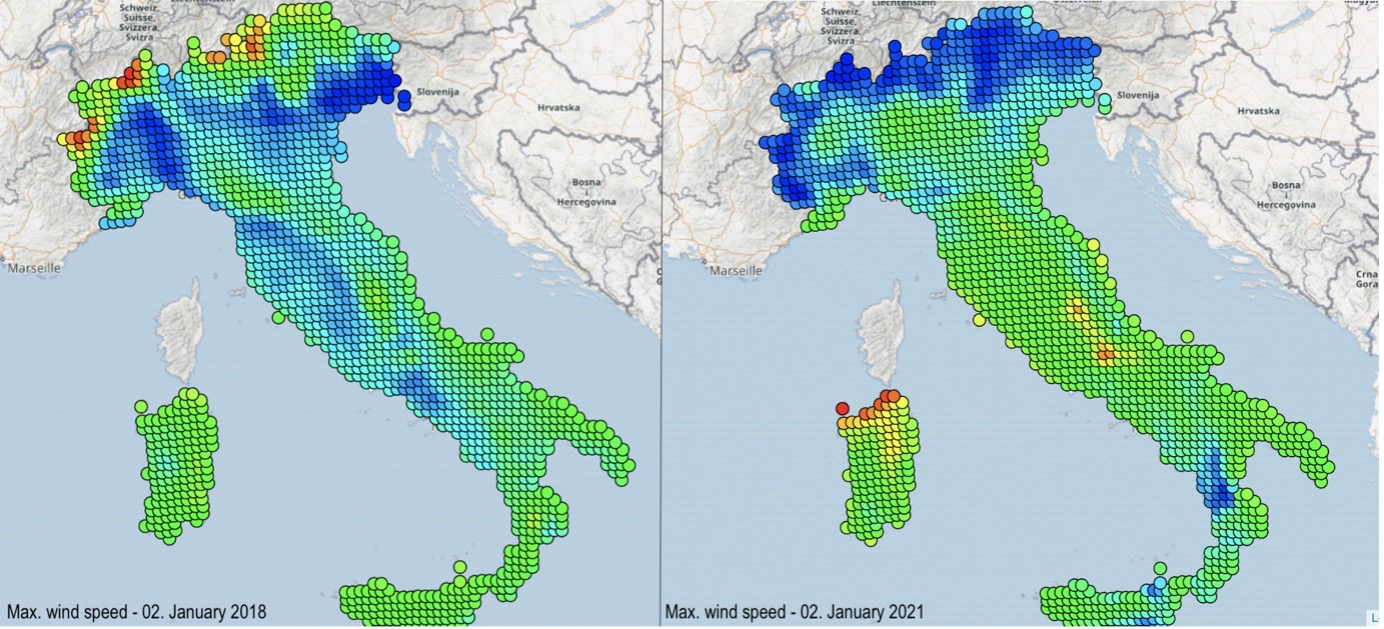


The API has been integrated within Sentinelhub to facilitate integration with EO data. In addition, a datacube has been published with relevant data over the Sahel Area (of interest for the Conflict Pre-waring Map Use Case).



In [8]:
band_names = [
    "CLOUD_COVER_TOTAL",
    "HUMIDITY",
    "PRECIPITATION",
    "PRESSURE",
    "SOIL_MOISTURE",
    "SUN_DURATION",
    "TEMPERATURE",
    "VAPOR_PRESSURE_DEFICIT",
    "WIND",
]

S2_africa_weather_data_collection = DataCollection.define_byoc(
    "0013507a-de28-4800-a890-394c493a51a3",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)

In [14]:
download_task_weather = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(band_names, "FLOAT32"),
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
    cache_folder = cache_folder,
)

In [15]:
eopatch_weather = download_task_weather.execute(bbox=bbox_meteo, time_interval=["2019-01-01", "2022-12-31"])

In [16]:
eopatch_weather

EOPatch(
  data={
    bands: numpy.ndarray(shape=(36, 220, 290, 9), dtype=float32)
  }
  bbox=BBox(((2.1823169415786765, 4.277408714530779), (15.420004728054494, 14.153692482188347)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2019, 1, 1, 0, 0), ..., datetime.datetime(2021, 12, 1, 0, 0)], length=36
)

In [17]:
variable_name = 'PRECIPITATION'

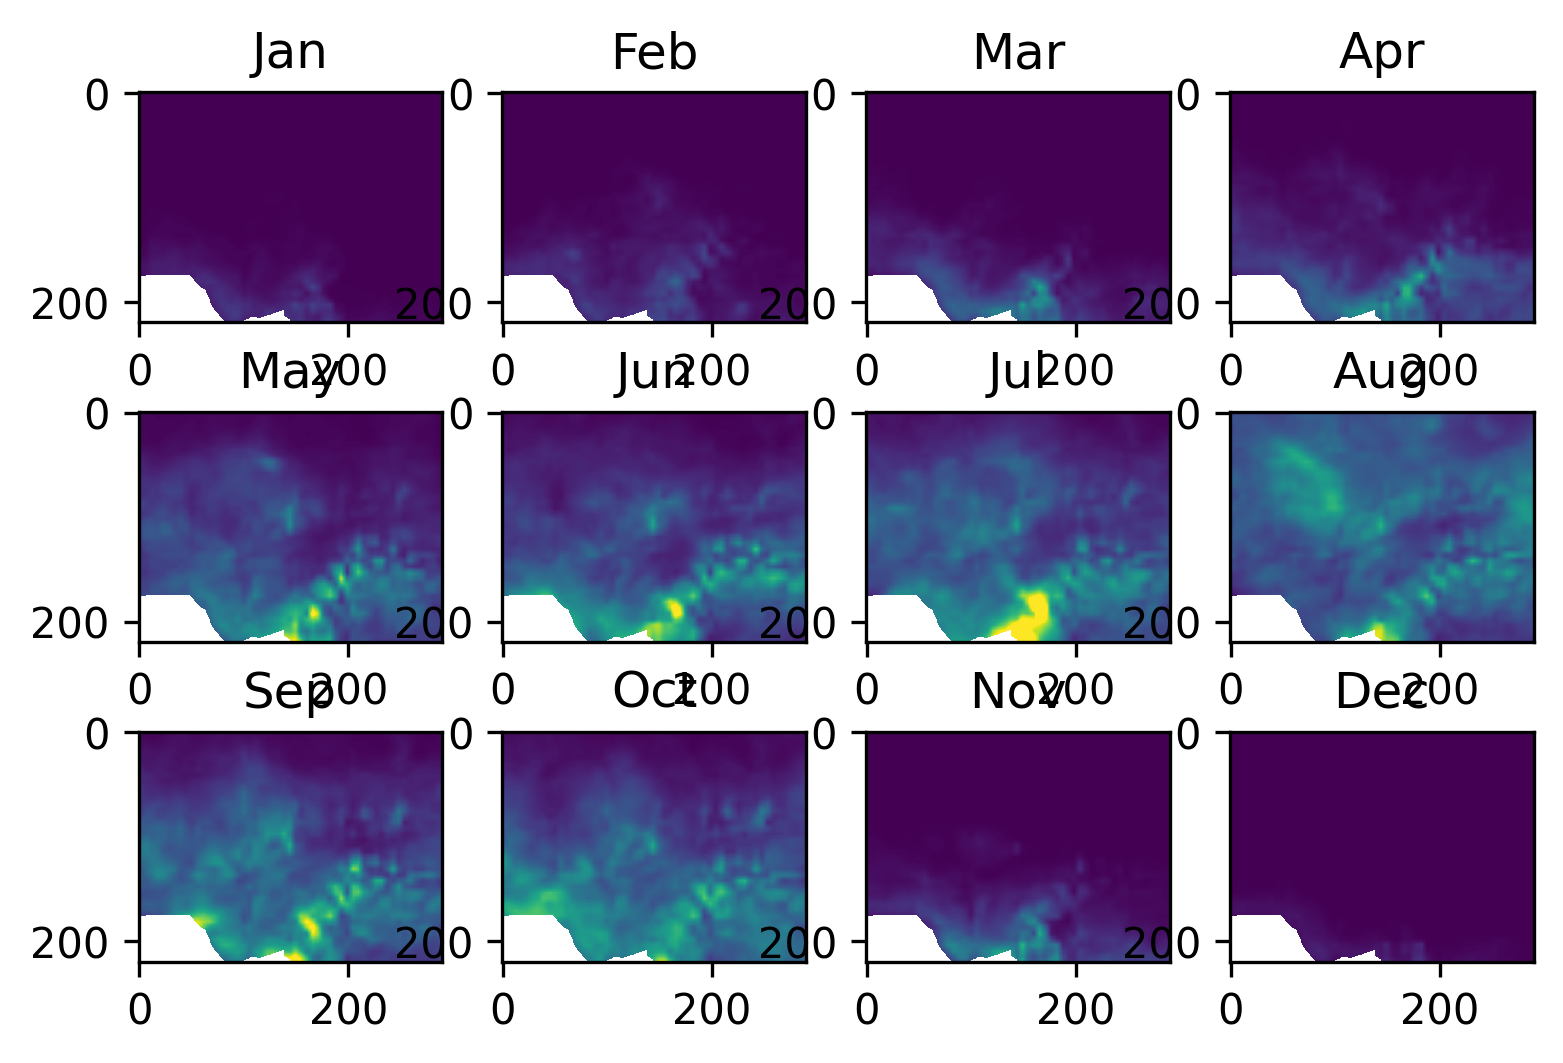

In [18]:
cols,rows = 3,4

fig, axs = plt.subplots(cols,rows, dpi=300)

for j,month in enumerate(months):
    n = math.floor(j/rows)
    m = j % rows
    im = axs[n,m].imshow(eopatch_weather.data['bands'][j][:,:,band_names.index(variable_name)], vmin=0, vmax=1)
    axs[n,m].set_title(month)


/opt/conda/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")



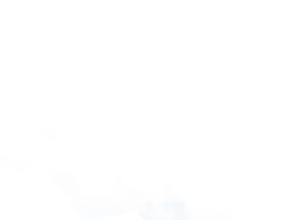
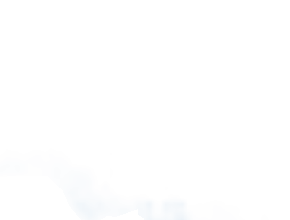
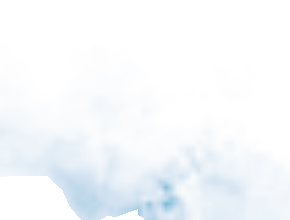
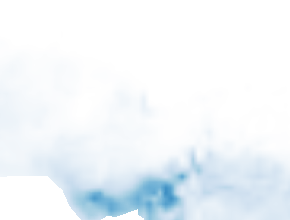
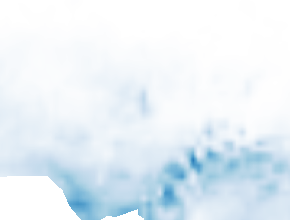
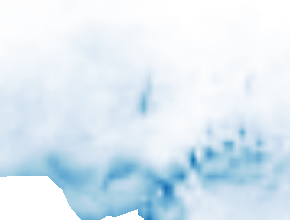
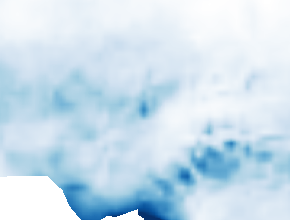
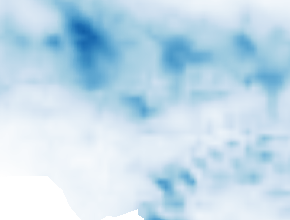
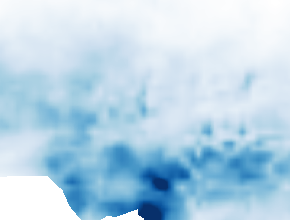
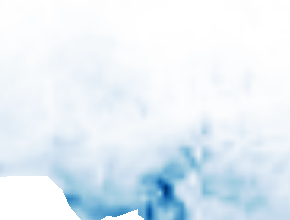
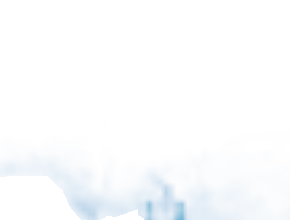
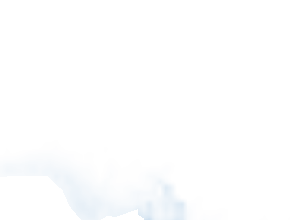

In [19]:
maps = [plot_tiff_folium(eopatch_weather.data['bands'][month][:,:,band_names.index(variable_name)], eopatch_weather.bbox.geometry.bounds, variable_name) for month in range(12,24)]

htmlmap = plot_multiple_foliums(maps,200,200)
display(htmlmap)

### Custom aggregation

If we aggregate the data over the region, we can take a look at e.g. the mean precipitations, which tends to peak in the months of May to October, with the flooding events peaking around August and October.

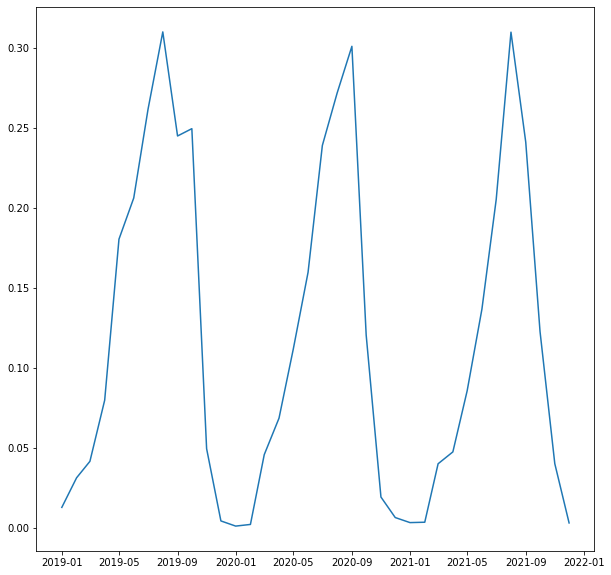

In [20]:
variable = eopatch_weather.data['bands'][:,:,:,band_names.index(variable_name)]

t,w,h = variable.shape

variable_mean = np.nanmean(variable.reshape(t,w*h), axis=1)

plt.figure(figsize=(10,10))
plt.plot(np.array(eopatch_weather.timestamp),variable_mean)


# Sentinel2 Data


Sentinel-2 is an Earth observation mission from the Copernicus Programme that systematically acquires multi-spectral (13 bands) imagery at high spatial resolution (10 m to 60 m) over land and coastal waters.

Sentinel-2 

### TODO show map with WMS Sentinel-2 and time enabled to visualize the TC and clouds?

In [21]:
s2_l2a_data = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    #bands_feature=(FeatureType.DATA, "L2A_data"),
    additional_data=[(FeatureType.MASK, "dataMask"),(FeatureType.MASK, "CLM")],
    resolution=resolution,
    maxcc=0.4,
    time_difference=dt.timedelta(hours=2),
    cache_folder = cache_folder,
)
eopatch_s2_l2a = s2_l2a_data.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-31"])

<AxesSubplot: title={'center': 'valid data'}>

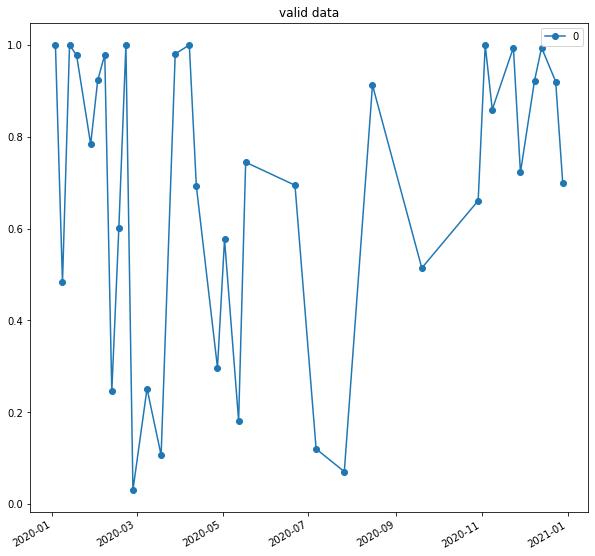

In [22]:
clouds = (eopatch_s2_l2a.mask['CLM'][:,:,:,0]==0) & (eopatch_s2_l2a.mask['dataMask'][:,:,:,0]==1)
t,w,h = clouds.shape

clouds_mean = np.nanmean(clouds.reshape(t,w*h), axis=1)

#plt.figure(figsize=(10,10))
#plt.plot(np.array(eopatch_s2_l2a.timestamp),clouds_mean)
pd.DataFrame(index=np.array(eopatch_s2_l2a.timestamp), data=clouds_mean).plot(marker='o',figsize=(10,10),title='valid data')


In [23]:
#band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A", "CLM"]
band_names = [ "B02", "B03", "B04",  "B08",]

africa_s2_data_collection = DataCollection.define_byoc(
    "fe60e85f-0648-4c54-b2dc-bbf725033813",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.uint16,)) for name in band_names],
)

In [24]:
download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(band_names, "UINT16"),
    data_collection=africa_s2_data_collection,
    resolution=resolution,
    max_threads=3,
    cache_folder = cache_folder,
)

In [25]:
eopatch = download_task.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-31"])

In [26]:
eopatch

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 296, 331, 4), dtype=uint16)
  }
  bbox=BBox(((6.625903941966982, 7.678229180820395), (6.9837551476568365, 8.001095807654053)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

In [27]:
b2 = eopatch.data["bands"][:][..., 0].squeeze()
b3 = eopatch.data["bands"][:][..., 1].squeeze()
b4 = eopatch.data["bands"][:][..., 2].squeeze()
b8 = eopatch.data["bands"][:][..., 3].squeeze()

ndwi = (b3-b8)/(b3+b8)

<ipython-input-27-aa25b4262df8>:6: RuntimeWarning: invalid value encountered in divide
  ndwi = (b3-b8)/(b3+b8)


In [28]:
def plot(title, names, data,vmin=None,vmax=None):
    ncols = 3
    nrows = math.ceil(len(data) / 3)

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
    fig.suptitle(title, y=0.93, size=16)

    for idx, _ in enumerate(data):
        if(vmin==None and vmax==None):
            ax[idx // ncols][idx % ncols].imshow(data[idx]*3/10000)
        else:
            ax[idx // ncols][idx % ncols].imshow(data[idx]*3/10000, vmin=vmin, vmax=vmax)
        ax[idx // ncols][idx % ncols].set_title(names[idx], size=12)
        ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
        ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

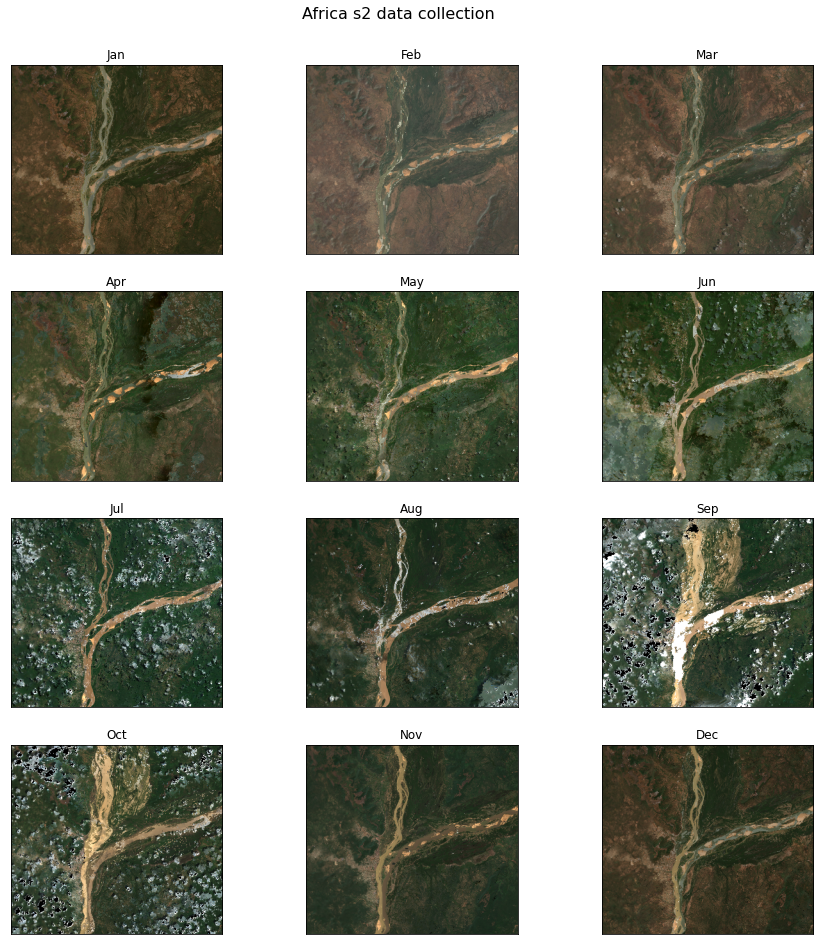

In [29]:
plot(
    "Africa s2 data collection",
    months,
    [eopatch.data["bands"][idx][:,:,[2,1,0]] for idx, _ in enumerate(months)],
)

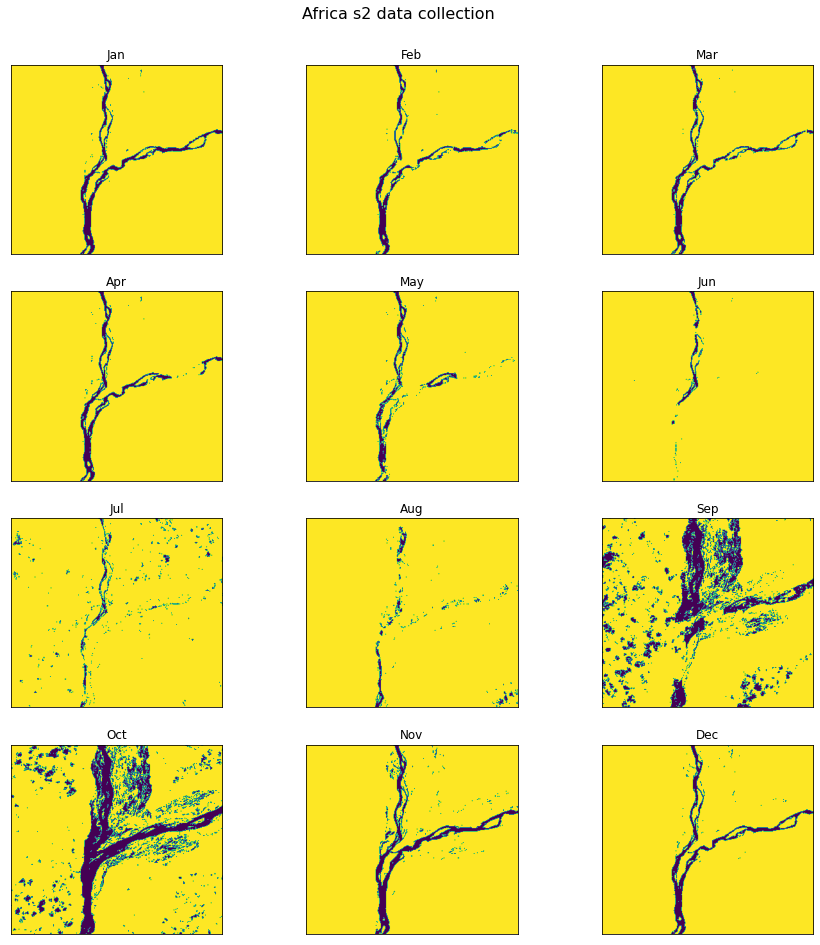

In [30]:
threshold=0.6

plot(
    "Africa s2 data collection",
    months,
    [ndwi[idx] > threshold for idx, _ in enumerate(months)]
)

### Sentinel-1

In [31]:
s1_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL1_IW_ASC,
    bands=["VV", "VH"],
    bands_feature=(FeatureType.DATA, "S1_data"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=resolution,
    time_difference=dt.timedelta(hours=2),
    cache_folder=cache_folder
)

eopatch_s1 = s1_task.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-31"])
#eopatch_s1.plot((FeatureType.DATA, "S1_data"), channels=[0, 1], channel_names=["VV", "VH"], config=config);

In [32]:
groups = [el.month for el in eopatch_s1.timestamp]
groups

indices_dict = {}

for i, number in enumerate(groups):
    if number in indices_dict:
        indices_dict[number].append(i)
    else:
        indices_dict[number] = [i]

monthly_mosaic = {}

for k,v in indices_dict.items():
    monthly_mosaic[k]= np.mean(eopatch_s1.data['S1_data'][v,:,:,0], axis=0)
    
monthly_mosaic

{1: array([[0.04211759, 0.03991738, 0.039928  , ..., 0.15556857, 0.1609592 ,
         0.26528427],
        [0.09482896, 0.03663426, 0.03339759, ..., 0.1429379 , 0.16105488,
         0.25448593],
        [0.10187165, 0.04927508, 0.10596   , ..., 0.20353422, 0.13999712,
         0.21324125],
        ...,
        [0.10602137, 0.10771659, 0.11164649, ..., 0.14000107, 0.11554685,
         0.1225787 ],
        [0.11777631, 0.14804581, 0.10918315, ..., 0.10964508, 0.10001244,
         0.10162749],
        [0.08960842, 0.11229694, 0.12874196, ..., 0.17524125, 0.15156412,
         0.14246173]], dtype=float32),
 2: array([[0.07707882, 0.0368538 , 0.04520501, ..., 0.15805048, 0.23690695,
         0.24824765],
        [0.13870966, 0.03684059, 0.03266089, ..., 0.12814045, 0.2281129 ,
         0.22534984],
        [0.14283082, 0.05119833, 0.08573309, ..., 0.10993676, 0.1508199 ,
         0.17150414],
        ...,
        [0.07364224, 0.08878753, 0.06516731, ..., 0.16656007, 0.14643675,
         0.13

In [33]:
indices_dict

{1: [0, 1],
 2: [2, 3],
 3: [4, 5],
 4: [6, 7, 8],
 5: [9, 10],
 6: [11, 12, 13],
 7: [14, 15, 16],
 8: [17, 18],
 9: [19, 20, 21],
 10: [22, 23],
 11: [24, 25, 26],
 12: [27, 28]}

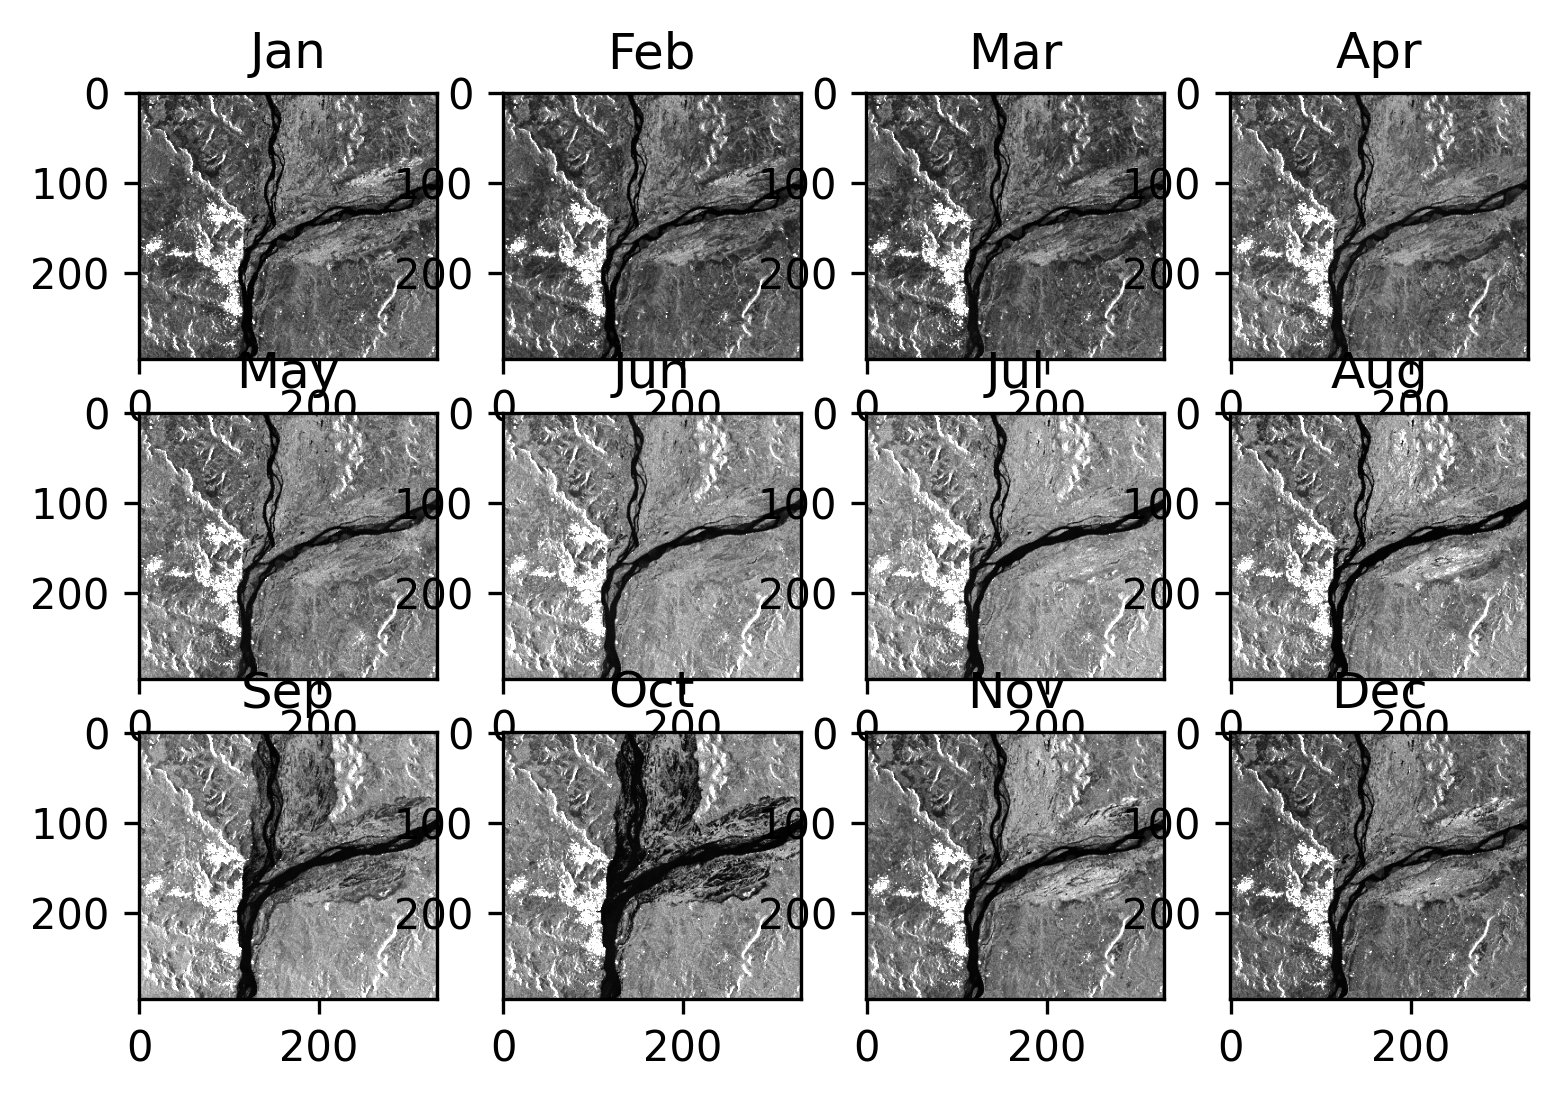

In [34]:
c = 3
r = 4
fig,ax = plt.subplots(c,r,dpi=300)

for k,v in monthly_mosaic.items():
    n = math.floor((k-1)/r)
    m = (k-1) % r
    ax[n,m].imshow(v,vmin=0,vmax=0.31,cmap='gray')
    ax[n,m].set_title(months[k-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


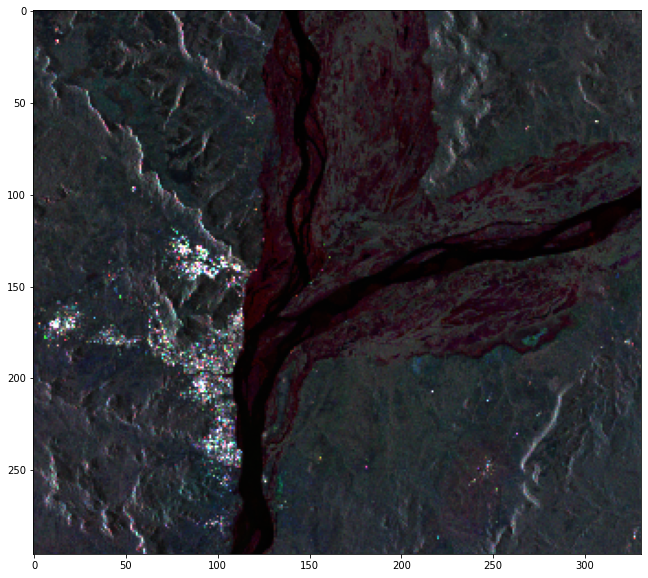

In [35]:
acd = np.dstack((monthly_mosaic[5],monthly_mosaic[10],monthly_mosaic[9]))

plt.figure(figsize=(15,10))
plt.imshow(acd,vmin=0,vmax=0.3)

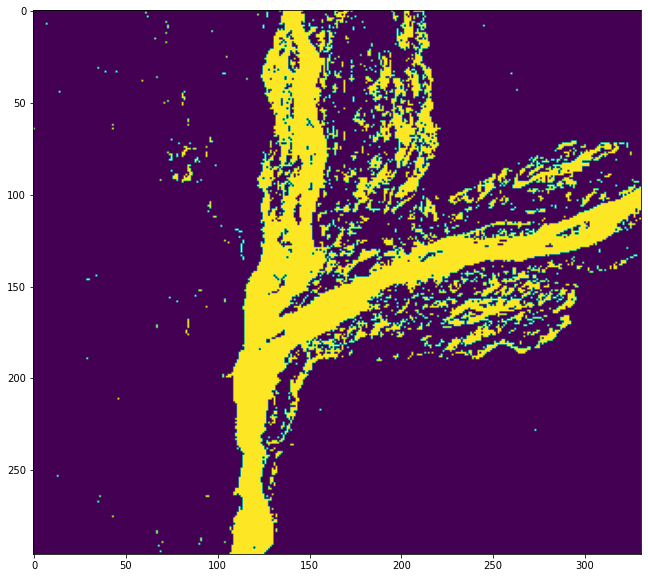

In [36]:
water = monthly_mosaic[10] < 0.06

plt.figure(figsize=(15,10))
plt.imshow(water)

### Get ESA Land Cover map

In [37]:
ewc_data_collection = DataCollection.define_byoc(
    "0b940c63-45dd-4e6b-8019-c3660b81b884",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name="Map", units=(Unit.DN,), output_types=(np.uint8,))],
)

evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["Map"],
    output: [
        {
          id: "EWC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.Map];
}
"""

In [38]:
ewc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "EWC_data"),
    evalscript=evalscript,
    data_collection=ewc_data_collection,
    resolution=resolution,
    max_threads=3,
    cache_folder = cache_folder,
)

In [39]:
eopatch_ewc = ewc_download_task.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-31"])

In [40]:
eopatch_ewc

EOPatch(
  data={
    EWC_data: numpy.ndarray(shape=(1, 296, 331, 1), dtype=uint8)
  }
  bbox=BBox(((6.625903941966982, 7.678229180820395), (6.9837551476568365, 8.001095807654053)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0)]
)

In [41]:

cols = eopatch_ewc.data['EWC_data'].shape[1]
rows = eopatch_ewc.data['EWC_data'].shape[2]

eopatch_ewc.data['EWC_data'].squeeze().reshape(cols, rows)

array([[20, 20, 10, ..., 10, 10, 10],
       [20, 20, 10, ..., 10, 10, 10],
       [20, 10, 20, ..., 10, 10, 10],
       ...,
       [20, 20, 20, ..., 10, 10, 10],
       [10, 20, 20, ..., 10, 10, 20],
       [20, 20, 20, ..., 10, 10, 10]], dtype=uint8)

In [42]:
ewc_cmap, ewc_norm, ewc_ticks, ewc_labels = construct_cmap(EWC, eopatch_ewc.data["EWC_data"], name="ewc_cmap")

In [43]:
ewc_data= eopatch_ewc.data['EWC_data'].squeeze().reshape(cols, rows)
np.unique(ewc_data, return_counts=True)


(array([10, 20, 30, 40, 50, 60, 80, 90], dtype=uint8),
 array([39515, 25706, 12651, 10072,  3058,  1011,  5253,   710]))

In [44]:
ewc_cmap = matplotlib.colors.ListedColormap(['darkgreen', 'orange', 'yellow','violet', 'red', 'dimgrey','blue', 'darkcyan'])
ewc_cmap

NameError: name 'matplotlib' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im1 = plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap, norm=ewc_norm)
plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap)
plt.axis(False)

cb = fig.colorbar(im1, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(ewc_ticks)
cb.set_ticklabels(ewc_labels);

In [ ]:

affected_crops = (ewc_data==40 & water)
affected_bua = (ewc_data==50 & water)


In [ ]:
unique, counts = np.unique(masked2, return_counts=True)
unique

In [ ]:
ewc_cmap2 = matplotlib.colors.ListedColormap(['black', 'darkgreen', 'orange', 'yellow', 'violet', 'red', 'dimgrey','blue', 'darkcyan'])
ewc_cmap2

In [ ]:
masked2 = ewc_data*water
plt.figure(figsize=(20,10))
plt.imshow(masked2,cmap=ewc_cmap2)

In [ ]:
unique, counts = np.unique(masked2, return_counts=True)
EWC_data = {i.values[1]:{'name': i.name} for i in list(EWC)}
values = dict(zip(unique.data,counts))

for i,val in values.items():
    if(i in EWC_data.keys()):
        EWC_data[i]['value'] = val
    else:
        print('key %s not found in EWC data' % str(i0))
    
plot_data = {i['name']:i['value'] if 'value' in i.keys() else 0 for i in list(EWC_data.values())}
del(plot_data['NO_DATA'])

df = pd.DataFrame(index=plot_data.keys(),data=plot_data.values(),columns=['value'])
df

In [ ]:
total_water_pixels = np.count_nonzero(water==True)

df['value'] = 100*df['value'] / total_water_pixels
df



In [ ]:
sns.heatmap(df,cmap='Reds')